# Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import random
import matplotlib.pyplot as plt
import seaborn as sns

Based off a similar [analysis](https://github.com/cyberscribe/d20datascience).

My goal was to create a method of simulating a fight in D&D as well as take my own approach of analyzing what character attributes matter in winning a fight.


Some day I would hope to implement as many features in D&D as I can, but in its current state, the simulator is essentially 2 robots taking turns slapping each other

In [3]:
'''
A character has the following stats

ability score, max hp, AC

but a character has at least 1 attack, which provides the following stats

attack modifier, damage dice, damage modifier
'''


class Character:
    def __init__(self,name="N/A",ability_score=[10,10,10,10,10,10], max_HP=10, AC=10):
        stats = ["STR","DEX","CON","INT","WIS","CHA"]
        
        self.name = name
        self.ability_score = {stats[i]:ability_score[i] for i in range(6)}
        self.mod = {stats[i]:(ability_score[i]-10)//2 for i in range(6)}
        self.max_HP = max_HP
        self.effective_HP = max_HP
        self.AC = AC
        
        self.opponents = [] # list of opponent names
        
    def __str__(self):
        print(f"Ability Scores: {self.ability_score}\n"
              f"Ability Modifiers: {self.mod}\n"
              f"HP: {self.effective_HP}\n"
              f"AC: {self.AC}")
        return f"Name: {self.name}"
    
    def dice_roll(self, dice=20, mod=0):
        roll = np.random.randint(1,dice+1)
        return roll + mod
    
    def reset_HP(self):
        self.effective_HP = self.max_HP
    def change_HP(self,HP_change):
        self.effective_HP += HP_change
        
    def set_atk(self,attack=None):
        if attack is None:
            self.attack=Attack()
        else:
            self.attack = attack
            
    def set_opponent(self,opponent):
        self.opponent = opponent
    def attack_opponent(self,num_attack=1):
        return self.attack.do_attack(num_attack)
        

In [ ]:
class Attack:
    def __init__(self,name="Attack",atk_mod=0,dmg_dice=6,dmg_mod=0):
        self.name = name
        self.atk_mod = atk_mod # hit rate
        self.dmg_dice = dmg_dice # damage
        self.dmg_mod = dmg_mod # damage
    
    def do_attack(self,n=1):
        attacks = np.random.randint(1,21,size=(n,1))+self.atk_mod
        damages = np.random.randint(1,self.dmg_dice+1,size=(n,1))+self.dmg_mod
        return np.concatenate((attacks,damages),axis=1)

In [ ]:
class Team:
    def __init__(self, name, members):
        mem = members # list of character objects
        self.name = name
        self.team_size = len(mem)
        members = {}
        
        total = 0
        for M in mem:
            members[M.name] = M
            total += M.max_HP
        self.members = members
        self.max_team_HP = total
        self.effective_team_HP = total
        
    def __str__(self):
        team_info = f"Team {self.name}\n\tTeam HP = {self.effective_team_HP},\n"
        character_info = [p.name + f"\n\tCharacter HP = {p.effective_HP}" for p in self.members.values()]
        return team_info + ",\n".join(character_info)
    
    def reset_team_HP(self):
        self.effective_team_HP = self.max_team_HP
        for M in self.members.values():
            M.reset_HP()
            M.opponents = []
            
    
    def change_team_HP(self, change_HP, *members):
        # *members = string of team members
        mems = [*members]
        for M in mems:
            self.effective_team_HP += change_HP


After the teams and characters have been established, we can set up the rules for combat

for each character  
--roll initiative  
while in combat  
--for each character (sorted by initiative)  
----check for lingering effects  
----decide character actions  
----check for other character reactions  

In [4]:
'''
for each character  
    roll initiative  
while in combat  
    for each character (sorted by initiative)  
        check for lingering effects  
        decide character actions  
        for each other character
            check for reactions
    if only 1 team left
        end combat
'''
        



class Battle:
    def __init__(self, TT):
        temp = TT # list of Team objects
        teams = {}
        everyone = {}
        wins = {}
        for T in temp:
            teams[T.name] = T
            wins[T.name] = []
            for M in T.members.values():
                everyone[M.name] = M
                
        self.teams = teams
        self.everyone = everyone
        self.wins = wins
        
        self.not_defeated = list(self.teams.keys()) # list of alive teams
        self.winners = [] # list of (winner, # rounds)
        
        
    def __str__(self):
        for T in self.teams.values():
            print(T)
        return ""
    
    def reset_defeat(self):
        self.not_defeated = list(self.teams.keys())
    
    def get_initiative(self):
        initiative = {}
        for e in self.everyone:
            p = self.everyone[e]
            initiative[e] = p.dice_roll(mod=p.mod['DEX'])
        
        # sort initiative by value descending
        self.initiative = dict(sorted(initiative.items(), key=lambda x:x[1], reverse=True))
        return self.initiative
    
    def get_team(self, member):
        for T in self.teams.values():
            if member in [M.name for M in T.members.values()]:
                return T.name
        print(f'Error: Team not found for {member}')
        
    
    def get_opponent(self,attacker):
        # attacker = string of attacker
        atk_team = self.get_team(attacker)
        p1 = self.everyone[attacker]
        
        # get list of possible targets
        if p1.opponents == []:
            targets = []
            for T in self.teams: # create list of potential targets
                if T != atk_team:
                    targets += [M.name for M in self.teams[T].members.values()]  
            p1.opponents = targets
        else: # preexisting list of targets
            targets = p1.opponents
            
            # check if any opponents died
            for p2 in list(set(targets)):
                if self.everyone[p2].effective_HP < 1: # if dead
                    targets = [pp for pp in targets if pp != p2] # remove from target list
        
        
        #randomly assign 1 target
        if len(targets) == 0:
            return None
        else:
            one_target = np.random.choice(targets,1)[0]
            # add in duplicate target
            p1.opponents = targets + [one_target]
            return one_target
    
    def get_character_object(self, name):
        assert name in self.everyone.keys(), f"Error: Could not find character with name {name}"
        return self.everyone[name]
    
    def check_defeated(self):
        # end when everyone in a team has <= 0 HP
        iter = 0
        for T in self.not_defeated:
            if self.teams[T].effective_team_HP < 1:
                self.not_defeated.pop(self.not_defeated.index(T))
            iter += 1
    
    def attack(self,p1, p2, num_attack = 1):
        attacker=self.everyone[p1]
        defender=self.everyone[p2]
        
        attack = attacker.attack_opponent(num_attack)
        def_team = self.teams[self.get_team(p2)]
        for atk, dmg in attack:
            if atk >= defender.AC: # if hit
                #print(f"\t\tHit for {dmg} damage")
                if dmg >= defender.effective_HP: # attack is greater than HP
                    def_team.change_team_HP(-defender.effective_HP,p2)
                    defender.change_HP(-defender.effective_HP)   
                else:
                    def_team.change_team_HP(-dmg,p2)
                    defender.change_HP(-dmg)
            else:
                pass
                #print("\t\tMissed")   
    def battle(self):
        for i in self.teams:
            self.teams[i].reset_team_HP()
        self.reset_defeat()
        
        initiative = self.get_initiative()
        rounds = 0
        while len(self.not_defeated) > 1 and rounds < 100:
            for attacker in initiative:
                if self.everyone[attacker].effective_HP > 0: # check if player is not dead
                    #print(f"Round {rounds}: {attacker}'s turn")
                    defender = self.get_opponent(attacker)
                    #print(Fight.everyone[attacker].opponents)
                    if defender is None:
                        break
            
                    self.attack(attacker, defender)
                    #print(Fight)
            self.check_defeated()
            rounds += 1
        
        if len(self.not_defeated) == 1:
            team_win = self.not_defeated[0]
            #print(f"Done, Team {team_win} won in {rounds} rounds")
            self.winners.append((team_win, rounds))
            self.wins[team_win].append(rounds)
            
        else:
            print("Error: Battle Finished with multiple teams alive")
        
        



        
            

In [9]:
'''
recording statistics
observing how varying each stat influences the outcome
1. randomize the stats
2. set up fights
3. record winning stats

* ability scores
* HP
* AC
* Attack mod
* Damage dice
* Damage mod

in 1v1, 2v1, 2v2

'''
class Statistics:
    def __init__(self,*kwargs):
        
        self.winners = pd.DataFrame()
        self.losers = pd.DataFrame()
        self.matches_list = [] # list of matches
        self.num_matches = 0
        self.columns = ["HP","AC","atk mod","dmg dice","dmg mod","STR","DEX","CON","INT","WIS","CHA"]
        
        
    def enter_data(self, df, team, wins):
        # team is a Team object
        # Team object to average attributes df
    
        aggregate_df = pd.DataFrame()
        for t in team.members:
            attributes = self.attr2pd(team.members[t],wins)
            aggregate_df = pd.concat([aggregate_df, attributes],axis=1)
            
        
        return pd.concat([df, pd.DataFrame(aggregate_df.mean(axis=0)).T], axis=0)
        
        
    def give_mean(self,df, col=None):
        if col is None:
            col = self.columns + ["wins"]
        means = pd.DataFrame(data={'mean': df[col].mean()})
        return means
    
    def attr2pd(self,character, wins):
        # character object to attribute df
        df = pd.DataFrame(data={
            'name':[character.name],
            'HP':[character.max_HP],
            'AC': [character.AC],
            'atk mod': [character.attack.atk_mod],
            'dmg dice': [character.attack.dmg_dice],
            'dmg mod': [character.attack.dmg_mod],
            'wins': [wins]
                })
        stats = {stat:[character.ability_score[stat]] for stat in character.ability_score}
        #print(pd.concat([df,pd.DataFrame(data=stats)], axis=1))
        return pd.concat([df,pd.DataFrame(data=stats)], axis=1)
    
    def gen_randoms(self,n=1000, teams=2, size=1):
        # n = number of randomly generated match ups, teams = number of teams, size = team size
        # output: match_list = [iter0, iter1, ..., itern], iter0=[Team0, Team1], Team0 = [Character0, Character1]
        self.num_matches = n
        
        randoms = pd.DataFrame(np.random.randint(1,21,(n*teams*size,11)),columns=self.columns) #11 parameters w/o name
        
        for i in range(n):
            TTeams = [] #carry sets of teams in an iteration
            for t in range(teams): 
                characters = [] # carry sets of characters in a team
                for s in range(size): 
                    index = i*teams*size+size*t+s # forumula to slice dataframe, derivation was trial and error
                    row = randoms.iloc[index] 
                    
                    c = Character(name=f"Character {index}",ability_score=[row["STR"],row["DEX"],row["CON"],row["INT"],row["WIS"],row["CHA"]], 
                          max_HP=row["HP"], AC=row["AC"])
                    c.set_atk(Attack(name="",atk_mod=row["atk mod"],dmg_dice=row["dmg dice"],dmg_mod=row["dmg mod"]))
                    characters.append(c)
                # done collecting all characters in a team
                T = Team(name=f"Team {index}", members = characters)
                TTeams.append(T)
            # done going through each team
            self.matches_list.append(TTeams)
        # done doing this n times

    def run_sim(self, n=100):
        # function to run simulation
        
        for i in range(self.num_matches):
            Fight = Battle(self.matches_list[i])
            
            # simulate n battles, winner has most wins on average
            for j in range(n):
                Fight.battle()
            
            # Find winning team
            results = {}
            max_wins = [0,""]
            for F in Fight.wins:
                wins = len(Fight.wins[F])
                results[F] = wins
                if wins > max_wins[0]:
                    max_wins = [wins, F]
            
            self.winners = self.enter_data(self.winners,Fight.teams[max_wins[1]],max_wins[0]) # enter winner
            
            for t in results:
                if t != max_wins[1]:
                    self.losers = self.enter_data(self.losers, Fight.teams[t],results[t]) # enter losers
                


            
            
            
            
            
    
        # work on recording the results into a df
        # then analysis can start
        # fix issue in fight where they take forever to finish

In [10]:

stat = Statistics()
stat.gen_randoms()
stat.run_sim()
stat.winners

,HP,AC,atk mod,dmg dice,dmg mod,wins,STR,DEX,CON,INT,WIS,CHA
0,6.0,4.0,10.0,8.0,12.0,79.0,15.0,16.0,5.0,4.0,19.0,8.0
0,3.0,7.0,7.0,16.0,6.0,67.0,9.0,18.0,13.0,16.0,3.0,1.0
0,17.0,5.0,14.0,7.0,7.0,97.0,16.0,4.0,17.0,4.0,3.0,17.0
0,10.0,19.0,17.0,19.0,20.0,65.0,2.0,3.0,13.0,9.0,10.0,12.0
0,1.0,18.0,18.0,10.0,14.0,52.0,13.0,11.0,11.0,16.0,14.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,8.0,13.0,1.0,20.0,17.0,56.0,2.0,9.0,4.0,4.0,17.0,20.0
0,19.0,14.0,14.0,17.0,11.0,100.0,7.0,20.0,17.0,17.0,11.0,3.0
0,14.0,4.0,18.0,14.0,3.0,82.0,2.0,13.0,17.0,11.0,9.0,5.0
0,16.0,14.0,18.0,17.0,11.0,92.0,2.0,2.0,2.0,8.0,16.0,20.0


<AxesSubplot:>

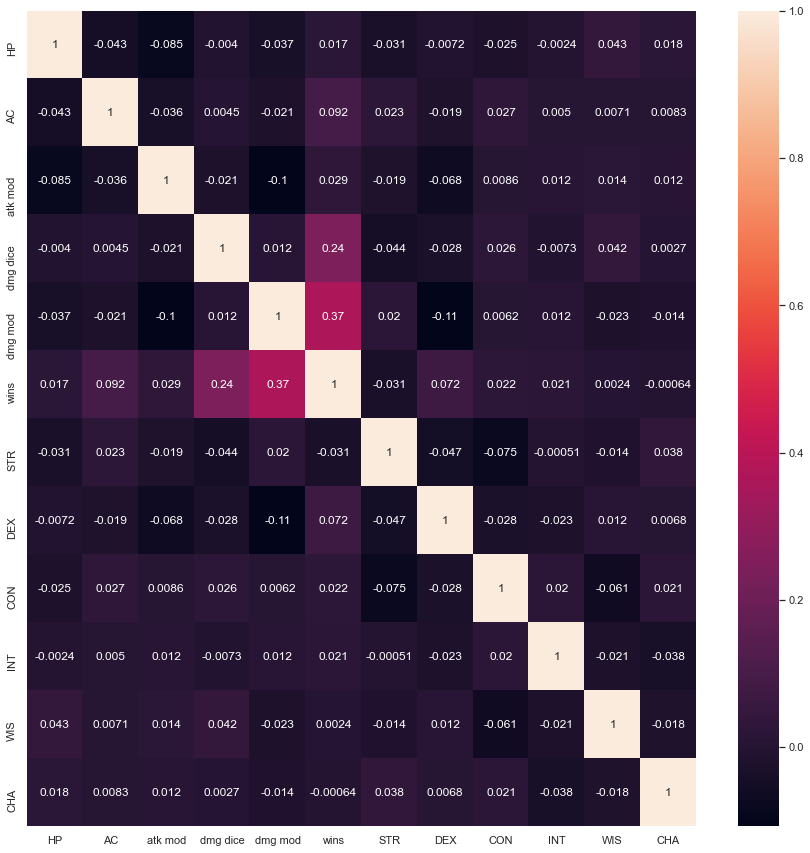

In [11]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(stat.losers.corr(method="pearson"),annot=True)

In [ ]:
plt.scatter(stat.winners["HP"],stat.winners["AC"])
plt.show()

In [ ]:
pd.DataFrame(stat.losers.mean()).T

In [ ]:
print(stat.matches_list[0][0])

# Mock Fight

Demonstrating the ability to have 2 teams of different sizes to fight each other

In [13]:
A1 = Character(name="A1")
A1.set_atk(Attack())
A2 = Character(name="A2")
A2.set_atk(Attack())
A3 = Character(name="A3")
A3.set_atk(Attack())
A4 = Character(name="A4")
A4.set_atk(Attack())

B1 = Character(name="B1")
B1.set_atk(Attack())
B2 = Character(name="B2")
B2.set_atk(Attack())
B3 = Character(name="B3")
B3.set_atk(Attack())
B4 = Character(name="B4")
B4.set_atk(Attack())


A = Team("A",[A1,A2])
B = Team("B",[B1,B2,B3,B4])


Fight = Battle([A,B])


In [16]:
for _ in range(1000):
    Fight.battle()
results = Fight.wins
for T in results:
    print(f"Team {T} won {len(results[T])} matches, lasting on average {np.mean(results[T])} rounds")

Team A won 5 matches, lasting on average 7.6 rounds
Team B won 2995 matches, lasting on average 3.4808013355592653 rounds
